Movie Recommendation System

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import libraries
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.patches as mpatches

In [40]:
# To save computation costs and easier testing, we have used a debug mode here. In debug mode only partial dataset is
# use.
debug_mode = True
#debug_mode = False

# Again, to save computation cost and easier testing we shall be saving the item-item weighted matrix in a pickle file 
# and load it whenever we need to use it. If we need to recompute it we shall set the load_existing_weighted_matrix to
# False
load_existing_weighted_matrix = True
#load_existing_weighted_matrix = False

In [23]:
# load movielens database which comprises of 3 files.
# Ratings which has a 100,000 ratings from 700 users for 9,000 movies
# Tags has 1300 tags applied to different movies by the users. e.g. - Sandra "boring" Bullock 
# Movies has details of the 9,000 movies. Such as title, release date, duration, genre etc.
df_ratings = pd.read_csv("ratingsgit.csv", encoding='"ISO-8859-1"')
df_tags = pd.read_csv("tagsgit.csv", encoding='"ISO-8859-1"')
df_movies = pd.read_csv("moviesgit.csv", encoding='"ISO-8859-1"')
 
df_ratings.shape

(100004, 4)

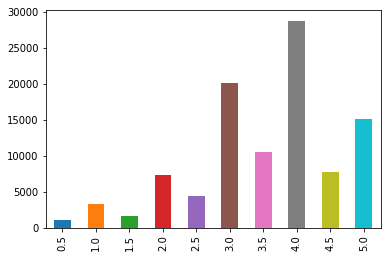

In [24]:
# Checkout the distribution of ratings
df_ratings['rating'].value_counts().sort_index().plot(kind='bar')


In [25]:
# Slice out partial dataset for debug mode
if debug_mode == True:
    df_movies = df_movies[df_movies['movieId'] < 1000]
    df_ratings = df_ratings[(df_ratings['movieId'] < 1000) & (df_ratings['userId'] < 100)]
print(df_movies.shape, df_ratings.shape)

(807, 3) (3760, 4)


In [26]:
# Split data into training and testing data in 70:30 ratio
df_ratings_training = df_ratings.sample(frac=0.7)
df_ratings_testing = df_ratings.drop(df_ratings_training.index)

In [27]:
# create file where the weighted matrix will be stored/persisted
if debug_mode == True:
    DEFAULT_FILE_PATH = 'i_w_m_debug.pkl'
else:
    DEFAULT_FILE_PATH = 'i_w_m.pkl'

In [28]:
# Compute adjusted ratings based on the training data
# Different users have different optimism levels. A user might rate a movie they like as 5 and another user may rate it
# as 4. So we normalise the ratings. So we calculate the mean rating for each movie
df_rating_mean= df_ratings_training.groupby(['movieId'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['movieId','rating_mean']]
#print(df_rating_mean.shape)
#print(df_rating_mean.iloc[:3])
# merge mean rating with the training data
df_adjusted_ratings = pd.merge(df_ratings_training,df_rating_mean,on = 'movieId', how = 'left', sort = False)
#print(df_adjusted_ratings.iloc[:3])
# Calculate adjusted rating for each movie rating by subtracting mean rating from actual rating
df_adjusted_ratings['rating_adjusted']=df_adjusted_ratings['rating']-df_adjusted_ratings['rating_mean']
#print(df_adjusted_ratings.iloc[:3])
# replace adjusted rating with zero values to 1*e-8 in order to avoid zero as denominator for further calculations
df_adjusted_ratings.loc[df_adjusted_ratings['rating_adjusted'] == 0, 'rating_adjusted'] = 1e-8
#print(df_adjusted_ratings.iloc[:3])
#print(df_adjusted_ratings.loc[df_adjusted_ratings['rating_adjusted'] == 1e-8])

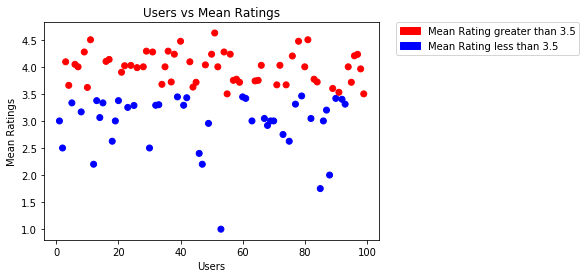

In [29]:
# plot the graph of the mean ratings of each user to undersatnd what is their optimism levels while rating movies
df_unique_users = df_adjusted_ratings.drop_duplicates('userId', keep='last')
#print(df_unique_users.iloc[:3])
#print(df_unique_users.shape)
col = np.where(df_unique_users.userId<0,'k',np.where(df_unique_users.rating_mean<3.5,'b','r'))
plt.scatter(df_unique_users.userId,df_unique_users.rating_mean,c = col)
plt.title("Users vs Mean Ratings")
plt.xlabel("Users")
plt.ylabel("Mean Ratings")
# build the legend
red_patch = mpatches.Patch(color='red', label='Mean Rating greater than 3.5')
blue_patch = mpatches.Patch(color='blue', label='Mean Rating less than 3.5')

# set up for handles declaration
patches = [red_patch, blue_patch]

# alternative declaration for placing legend outside of plot
legend = plt.legend(handles=patches,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [30]:
# build item-item weighted matrix

def build_weighted_matrix(df_adjusted_ratings, load_existing_weighted_matrix):
    # define weighted matrix
    weighted_matrix_columns = ['movie_1', 'movie_2', 'weight']
    weighted_matrix = pd.DataFrame(columns = weighted_matrix_columns)

    # load weighted matrix from the persistent pickle file
    if load_existing_weighted_matrix:
        with open(DEFAULT_FILE_PATH, 'rb') as input:
            weighted_matrix = pickle.load(input)
        input.close()

    # calculate the cosine similarity values for the weighted matrix
    else:
    # compute the unique movies from the list of all the movies
        unique_movies = np.unique(df_adjusted_ratings['movieId'])

        i = 0
        # for each movie 1 in the list of all movies
        for movie_1 in unique_movies:
            #print value of i at a step of 100 to keep track of the weighted matrix creation process
            if i%100==0:
                print(i , "out of ", len(unique_movies))

            # extract all users who rated movie 1
            df_user_data = df_adjusted_ratings[df_adjusted_ratings['movieId'] == movie_1]
            
            unique_users = np.unique(df_user_data['userId'])

            # store the ratings for users who rated both movie 1 and movie 2
            matrix_row_columns = ['userId', 'movie_1', 'movie_2', 'rating_adjusted_1', 'rating_adjusted_2']
            matrix_movie_1_2 = pd.DataFrame(columns=matrix_row_columns)
            # Loop through all customers whorated movie 1
            for a_userid in unique_users:
                # Extract the rating for movie 1 by cutomer
                a_movie_1_rating = df_user_data[df_user_data['userId'] == a_userid]['rating_adjusted'].iloc[0]
                # extract movies rated by the customer leaving OUT movie 1
                a_user_data = df_adjusted_ratings[(df_adjusted_ratings['userId'] == a_userid) & (df_adjusted_ratings['movieId'] != movie_1)]
                a_unique_movies = np.unique(a_user_data['movieId'])

                # loop through all movies rated by customer A. We will call it movie 2 
                for movie_2 in a_unique_movies:
                    # Extract rating by customer for second movie(movie_2)
                    a_movie_2_rating = a_user_data[a_user_data['movieId'] == movie_2]['rating_adjusted'].iloc[0]
                    matrix_row = pd.Series([a_userid, movie_1, movie_2, a_movie_1_rating, a_movie_2_rating], index=matrix_row_columns)
                    matrix_movie_1_2 = matrix_movie_1_2.append(matrix_row, ignore_index=True)

            # Compute the cosine similarity between the movies extracted above and movie 1
            unique_movie_2 = np.unique(matrix_movie_1_2['movie_2'])
            # Looping through all the movies for computing similiraity
            for movie_2 in unique_movie_2:
                pair_movie_1_2 = matrix_movie_1_2[matrix_movie_1_2['movie_2'] == movie_2]
                csim_value_numerator = (pair_movie_1_2['rating_adjusted_1'] * pair_movie_1_2['rating_adjusted_2']).sum()
                csim_value_denominator = np.square(pair_movie_1_2['rating_adjusted_1'].sum()) * np.square(pair_movie_1_2['rating_adjusted_2'].sum())
                csim_value_denominator = csim_value_denominator if csim_value_denominator != 0 else 1e-8
                csim_value = csim_value_numerator / csim_value_denominator
                weighted_matrix = weighted_matrix.append(pd.Series([movie_1, movie_2, csim_value], index=weighted_matrix_columns), ignore_index=True)

            i = i + 1

        # save weighted matrix as a pickle file
        with open(DEFAULT_FILE_PATH, 'wb') as output:
            pickle.dump(weighted_matrix, output, pickle.HIGHEST_PROTOCOL)
        output.close()

    return weighted_matrix


In [31]:
# run the function to build similarity matrix
weighted_matrix = build_weighted_matrix(df_adjusted_ratings, load_existing_weighted_matrix)
print('done')
print(weighted_matrix.iloc[:3])
weighted_matrix.shape

0 out of  506
100 out of  506
200 out of  506
300 out of  506
400 out of  506
500 out of  506
done
   movie_1  movie_2      weight
0      1.0      2.0  191.302431
1      1.0      3.0    4.257015
2      1.0      5.0    1.872154


(102582, 3)

The below formula was used to predict ratings of the users

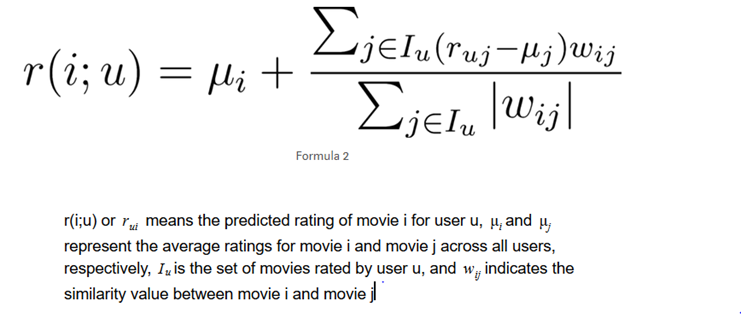

In [32]:
# compute the predicted ratings for the user
def predict_ratings(userId, movieId, weighted_matrix, df_adjusted_ratings, df_rating_mean):
    # We will solve the missing df_rating_mean which was due to no ratings being present for the given movie
    
    # if the rating exist for the movie ID passed as an argument
    if df_rating_mean[df_rating_mean['movieId'] == movieId].shape[0] > 0:
        mean_rating = df_rating_mean[df_rating_mean['movieId'] == movieId]['rating_mean'].iloc[0]
        #print(mean_rating)
    # if mean_rating is missing for the given movieId(because nobody has rated the movie)
    else:
        mean_rating = 2.5

    # compute the predicted rating of the movie by the user
    df_user_other_ratings = df_adjusted_ratings[df_adjusted_ratings['userId'] == userId]
    #print(df_user_other_ratings.iloc[:3])
    user_unique_movies = np.unique(df_user_other_ratings['movieId'])
    #print(user_unique_movies)
    weighted_sum_other_ratings = 0
    sum_weights = 0
    for movie_j in user_unique_movies:
        if df_rating_mean[df_rating_mean['movieId'] == movie_j].shape[0] > 0:
            df_rating_mean_j = df_rating_mean[df_rating_mean['movieId'] == movie_j]['rating_mean'].iloc[0]
            #print("rating mean j", df_rating_mean_j)
        else:
            df_rating_mean_j = 2.5
        # only compute the weighted values if the wighted matrix has a similarity weight between movie 1 and 2
        weighted_movie_1_2 = weighted_matrix[(weighted_matrix['movie_1'] == movieId) & (weighted_matrix['movie_2'] == movie_j)]
        #print( weighted_movie_1_2)
        if weighted_movie_1_2.shape[0] > 0:
            user_rating_j = df_user_other_ratings[df_user_other_ratings['movieId']==movie_j]
            #print("user rating j",user_rating_j)
            weighted_sum_other_ratings += (user_rating_j['rating'].iloc[0] - df_rating_mean_j) * weighted_movie_1_2['weight'].iloc[0]
            #print("sum weighted other ratings", weighted_sum_other_ratings)
            sum_weights += np.abs(weighted_movie_1_2['weight'].iloc[0])
            #print("sum weights", sum_weights)
    # use the mean rating if sum of weights is zero. it might be because there is no rating from new users
    if sum_weights == 0:
        predicted_rating_for_movie = mean_rating
    # sum_weights is greater than 0
    else:
        predicted_rating_for_movie = mean_rating + weighted_sum_other_ratings/sum_weights
        #print("predicted rating for movie", predicted_rating_for_movie)
    return predicted_rating_for_movie

In [33]:
# Based on the movie and user id predit rating for that movie for that user
predicted_rating = predict_ratings(2, 29, weighted_matrix, df_adjusted_ratings, df_rating_mean)
print('The predicted rating: %f' % predicted_rating)

The predicted rating: 3.701480


In [34]:
# Convert rating to positive and negative to evaluate the model using precision and recall
def binary_evaluation(df_ratings_testing, weighted_matrix, df_adjusted_ratings, df_rating_mean):
    # All the ratings are predicted for the testdata
    df_ratings_testing = df_ratings_testing.assign(predicted_rating = pd.Series(np.zeros(df_ratings_testing.shape[0])))
    for index, row_rating in df_ratings_testing.iterrows():
        predicted_rating = predict_ratings(row_rating['userId'], row_rating['movieId'], weighted_matrix, df_adjusted_ratings, df_rating_mean)
        df_ratings_testing.loc[index, 'predicted_rating'] = predicted_rating
    true_positive = df_ratings_testing.query('(rating >= 2.5) & (predicted_rating >= 2.5)').shape[0]
    false_positive = df_ratings_testing.query('(rating < 2.5) & (predicted_rating >= 2.5)').shape[0]
    false_negative = df_ratings_testing.query('(rating >= 2.5) & (predicted_rating < 2.5)').shape[0]

    # calculate the precision and recall
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    return (precision, recall)

In [35]:
# run the evaluation for the results on precision and recall
evaluate_result = binary_evaluation(df_ratings_testing, weighted_matrix, df_adjusted_ratings, df_rating_mean)
print('Result - precision: %f, recall: %f' % evaluate_result)

Evaluation result - precision: 0.906838, recall: 0.907738


In [38]:
# Finally make recommendations of 10 movies to user
def movie_recommendations(userID, weighted_matrix, df_adjusted_ratings, df_rating_mean, quantity=10):
    unique_movies = np.unique(df_adjusted_ratings['movieId'])
    df_user_ratings_all_movies = pd.DataFrame(columns=['movieId', 'rating'])
    df_user_rating = df_adjusted_ratings[df_adjusted_ratings['userId']==userID]

    # compute the ratings for all the movies not rated by the user
    i = 0
    for movie in unique_movies:
        df_user_rating = df_user_rating[df_user_rating['movieId']==movie]
        if df_user_rating.shape[0] > 0:#if movie already has a rating
            rating = df_user_ratings_all_movies.loc[i, 'rating'] = df_user_rating.loc[0, movie]
        else:#predict the rating the user would give it
            rating = df_user_ratings_all_movies.loc[i, 'rating'] = predict_ratings(userID, movie, weighted_matrix, df_adjusted_ratings, df_rating_mean)
        df_user_ratings_all_movies.loc[i] = [movie, rating]

        i+=1

    # Sort movies by rating and select he requested number of recommendations
    recommendations = df_user_ratings_all_movies.sort_values(by=['rating'], ascending=False).head(quantity)
    return recommendations

In [37]:
#Get a list of movie recommnedations for a user
recommended_movies = movie_recommendations(2, weighted_matrix, df_adjusted_ratings, df_rating_mean)
print(recommended_movies)

    movieId   rating
205     328  6.71428
91      150  6.46395
455     898  5.86363
156     250  5.57977
400     720   5.5277
368     611   5.5082
142     230  5.49364
285     465  5.49364
385     668  5.31697
253     412  5.26087


In [39]:
# Compating users top movies vs recommended movies
def liked_movies_vs_recommended_movies(user_id,recommended_movies):
    #Get users top movies
    df_top_movies = df_adjusted_ratings[df_adjusted_ratings['userId'] == user_id]
    df_top_movies = df_top_movies.sort_values(by=['rating'], ascending=False).head(10)
    #print(df_top_movies)
    #print(movies.iloc[:3])
    #Merge with movies dataset to get movie names and genres
    df_top_movies = pd.merge(df_top_movies,df_movies,on = 'movieId', how = 'left', sort = False)
    print(df_top_movies)
    #Merge with movies dataset to get movie names and genres
    df_recommended_movies = pd.merge(recommended_movies,df_movies, on = 'movieId', how = 'left', sort = False)
    print(df_recommended_movies)
    
liked_movies_vs_recommended_movies(2,recommended_movies)

   userId  movieId  rating  timestamp  rating_mean  rating_adjusted  \
0       2      592     5.0  835355395     3.619048         1.380952   
1       2      150     5.0  835355395     3.770833         1.229167   
2       2      590     5.0  835355395     3.739130         1.260870   
3       2      551     5.0  835355767     3.318182         1.681818   
4       2       17     5.0  835355681     3.875000         1.125000   
5       2      515     4.0  835355817     3.687500         0.312500   
6       2      273     4.0  835355779     3.250000         0.750000   
7       2      500     4.0  835355731     3.500000         0.500000   
8       2      261     4.0  835355681     3.562500         0.437500   
9       2      153     4.0  835355441     3.666667         0.333333   

                                               title  \
0                                      Batman (1989)   
1                                   Apollo 13 (1995)   
2                          Dances with Wolves (199